In [1]:
import jax
from jax import numpy as jnp
import equinox as eqx
from energax.ebms.nn_ebms import ContinuousNNEBM
from energax.nns import MLP
from energax.sampling.continuous import LangevinSampler
from energax.losses import contrastive_divergence
from sklearn.datasets import make_blobs
import optax
import matplotlib.pyplot as plt
from energax.optimizers import ngd_constructor
from functools import partial

In [2]:
key = jax.random.PRNGKey(42)

In [3]:
data = make_blobs(1_000, centers=2, n_features=2, cluster_std=0.2, random_state=42)
data = data[0]
data[:, 0] = (
    2 * (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0])) - 1
)
data[:, 1] = (
    2 * (data[:, 1] - min(data[:, 1])) / (max(data[:, 1]) - min(data[:, 1])) - 1
)
data = jnp.array(data)
data = data
print(data.shape)

(1000, 2)


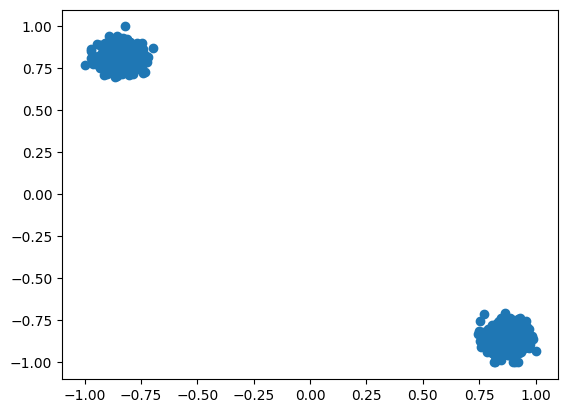

In [4]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [5]:
def test_plot(ebm):
    inits = jax.vmap(lambda x: jax.random.uniform(x, minval=-1, maxval=1, shape=(2,)))(
        jax.random.split(key, 500)
    )
    sampler_test = LangevinSampler((2,), 500, -1.0, 1.0, sampling_step_size, sigma, 30)
    gen_samples = sampler_test.sample_chains(ebm, inits, key)["position"]

    plt.scatter(data[:, 0], data[:, 1], label="Real", s=10)
    plt.scatter(gen_samples[:, 0], gen_samples[:, 1], label="Fake", s=10)
    plt.scatter(inits[:, 0], inits[:, 1], label="Fake Init", s=10)
    plt.legend()
    plt.show()
    plt.clf()

0.009830236


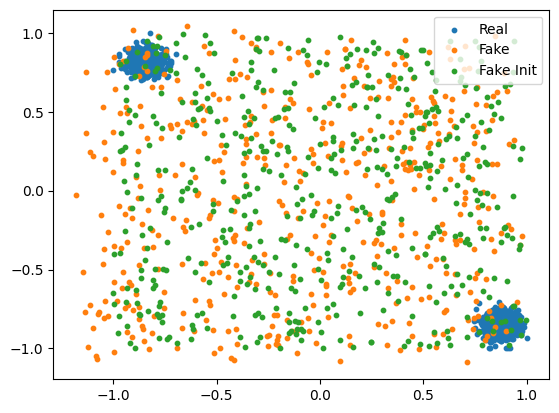

<Figure size 640x480 with 0 Axes>

In [7]:
epochs = 10  # 50
batch_size = 256
sampling_steps = 40
sampling_step_size = 0.1
sigma = 0.01
regularization = 0.0

key, subkey = jax.random.split(key, 2)
nn = MLP(dims=2, depth=3, width=10, key=subkey)
ebm = ContinuousNNEBM(nn=nn)
sampler = LangevinSampler(
    (2,), batch_size, -1, 1, sampling_step_size, sigma, sampling_steps
)

optimizer = optax.sgd(1.0)
opt_state = optimizer.init(eqx.filter(ebm, eqx.is_array))

loss = partial(contrastive_divergence, regularization=regularization)
ngd_update = ngd_constructor(loss, maxiter=10)
# ngd_update = ngd_constructor_full_metric(loss, inverse="penrose")


@eqx.filter_jit
def step(mlp, real_batch, sample_batch_Z, opt_state):
    updates, value = ngd_update(mlp, real_batch, sample_batch_Z)
    updates, opt_state = optimizer.update(updates, opt_state, mlp)
    mlp = eqx.apply_updates(mlp, updates)
    return mlp, opt_state, value


for epoch in range(epochs):
    subkey, subkey1 = jax.random.split(key, 2)
    sample_batch_Z = jax.lax.stop_gradient(sampler.sample_chains(ebm, None, subkey1))[
        "position"
    ]

    inds = jax.random.randint(subkey, minval=0, maxval=len(data), shape=(batch_size,))
    real_batch = data[inds]

    ebm, opt_state, value = step(ebm, real_batch, sample_batch_Z, opt_state)
    if epoch % 10 == 0:
        print(value)
        test_plot(ebm)